<a href="https://colab.research.google.com/github/imeunu/Capstone_PBL/blob/main/%EB%BC%88%EB%8C%80_cnn%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
from os import listdir
from os.path import join
import pandas as pd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim
import librosa
import IPython as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings 
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_dir= '/content/drive/MyDrive/화자인식/뼈대용 화자'
j=0
X=[]
Y=[]
speaker_list= os.listdir(path_dir) #00f.../ 0b.../ 0c7...

for speaker in speaker_list: #00f.../ 0b.../ 0c7...
    
  file_list= os.listdir(path_dir+'/'+str(speaker)) # one, two, three...
  for filename in file_list:
    wav_list= os.listdir(path_dir + '/' + str(speaker)+ '/'+str(filename)) # wav파일
    for wav_file in wav_list:
      #피처 추출
      wav_file_adress= path_dir + '/' + str(speaker)+ '/'+str(filename)+'/'+str(wav_file)
      x= librosa.load(wav_file_adress, 160000)[0]
      y= librosa.stft(x, n_fft= 128, hop_length= 128, win_length=128)

      magnitude= np.abs(y)
      log_spectrogram= librosa.amplitude_to_db(magnitude)


      X.append(log_spectrogram)
      Y.append(str(speaker))

In [ ]:
X=np.asarray(X)

In [ ]:
X.shape

(87, 65, 1251)

In [ ]:
Y= np.asarray(Y)
## 라벨링
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(Y)
Y=le.transform(Y)
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## train val test 분리

In [ ]:
# 7 : 1.5 : 1.5로 일단 분리
from sklearn.model_selection import train_test_split

X_train, X_save, y_train, y_save= train_test_split(X, Y, test_size= 0.3)
X_test, X_val, y_test, y_val= train_test_split(X_save, y_save, test_size= 0.5)

X_train= np.asarray(X_train)
X_val= np.asarray(X_val)
X_test=np.asarray(X_test)
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(60, 65, 1251) (13, 65, 1251) (14, 65, 1251)
(60,) (13,) (14,)


In [ ]:
train_X= np.expand_dims(X_train, -1)
val_X=np.expand_dims(X_val,-1)
test_X= np.expand_dims(X_test, -1)


In [ ]:
from keras import models
from keras import layers
import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


#Define Model
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(65, 1251,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(train_X,
                    y_train,
                    validation_data=(val_X, y_val),
                    epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 325ms/step - loss: 1121.0328 - accuracy: 0.3271 - val_loss: 2701.5005 - val_accuracy: 0.3571
Epoch 2/100
2/2 [==============================] - 0s 146ms/step - loss: 2247.9061 - accuracy: 0.2826 - val_loss: 655.7681 - val_accuracy: 0.2857
Epoch 3/100
2/2 [==============================] - 0s 143ms/step - loss: 988.0796 - accuracy: 0.3910 - val_loss: 245.1288 - val_accuracy: 0.3571
Epoch 4/100
2/2 [==============================] - 0s 150ms/step - loss: 228.6500 - accuracy: 0.3924 - val_loss: 2.2977e-04 - val_accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 0s 149ms/step - loss: 37.3458 - accuracy: 0.6486 - val_loss: 19.0795 - val_accuracy: 0.3571
Epoch 6/100
2/2 [==============================] - 0s 145ms/step - loss: 22.8029 - accuracy: 0.4354 - val_loss: 7.8128 - val_accuracy: 0.6429
Epoch 7/100
2/2 [==============================] - 0s 144ms/step - loss: 7.6730 - accuracy: 0.6958 - val_loss: 5.0834 - val_accura

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 63, 1249, 32)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 1247, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 623, 64)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 623, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1196160)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               153108608 
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

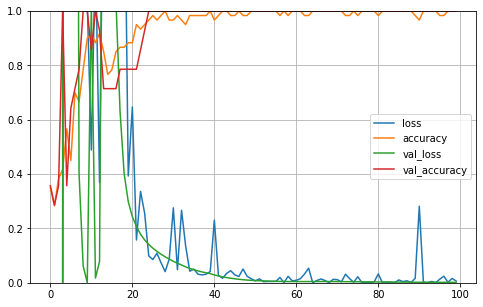

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
## Evaluate

test_loss, test_mae= model.evaluate(test_X, y_test)

1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - accuracy: 1.0000


In [ ]:
test_prediction= model.predict(test_X)
test_prediction

array([[9.65746582e-01, 3.38853449e-02, 3.68066307e-04],
       [9.99785960e-01, 2.13905674e-04, 1.40473318e-07],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [9.99990582e-01, 8.90190131e-06, 4.19533677e-07],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 7.94719644e-29],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [5.18152494e-23, 1.00000000e+00, 5.89166777e-14],
       [0.00000000e+00, 1.00000000e+00, 2.89324660e-35],
       [4.86013846e-21, 1.00000000e+00, 1.06085286e-10],
       [9.99997616e-01, 1.91705021e-06, 5.24623374e-07],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.27817345e-26, 1.00000000e+00, 4.69801960e-17]], dtype=float32)

In [ ]:
y_test

array([0, 0, 2, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1])

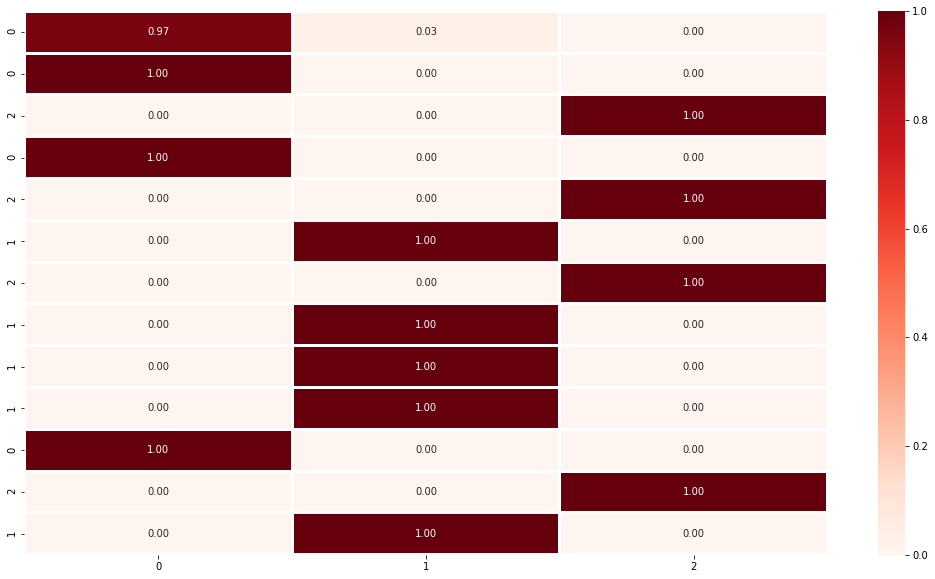

In [ ]:
import seaborn as sns

value= test_prediction
x=[0, 1 ,2]
df_eval= pd.DataFrame(value, columns=x, index= y_test)

fig, ax = plt.subplots(figsize=(18,10))    # figsize

ax = sns.heatmap(df_eval,
                 cmap="Reds",           # cmap Color
                 annot=True,            # Value Text
                 fmt=".2f",             # Value type (interge = "d")
                 linewidths=2)